In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def dechannelize(pulse):
    pulse = np.fft.irfft(pulse, axis=1)
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, pulse.shape[-1])
    else:
        pulse = pulse.ravel()
    return pulse

def correlate_power(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    #p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_phased = (p1fine) * np.conj(p2fine) / abs(p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def correlate_returnts(p1, p2, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_phased = dechannelize(p12_phased)
    return p12_phased

def Stokes(R,L):
    I = abs(R)**2.0 + abs(L)**2.0
    Q = 2*np.real(np.conj(L)*R)
    U = -2*np.imag(np.conj(L)*R)
    V = abs(R)**2.0 - abs(L)**2.0
    return I, Q, U, V

def channelize_ts(pulse, nchan):
    if len(pulse.shape) == 2:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def pad(ts,nzeros):
    ts = np.concatenate((ts,0*ts[:nzeros]), axis=0)
    return ts

In [3]:
def simGP(SN, irf, noise):

    length = (len(irf)-1)*2

    ts = np.zeros(length)
    ts[length//2] += 1

    ts_convolved = np.fft.irfft( (np.fft.rfft(ts) * irf) )
    psim = SN*ts_convolved + noise*np.random.normal(size=length)

    return psim

(4000, 5500)

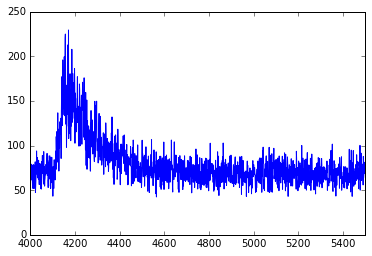

In [4]:
"""  Load Brightest Pulse """
p1 = np.load('ts2014-06-13T07:00:02.13597.npy')
p2 = np.load('ts2014-06-13T06:01:21.91125.npy')

data = p1.reshape(-1,4,6)
data = np.fft.rfft(data,axis=1)
plt.plot(abs(data).sum(1).sum(-1))
plt.xlim(4000,5500)

2.60190046337
1.01088299953


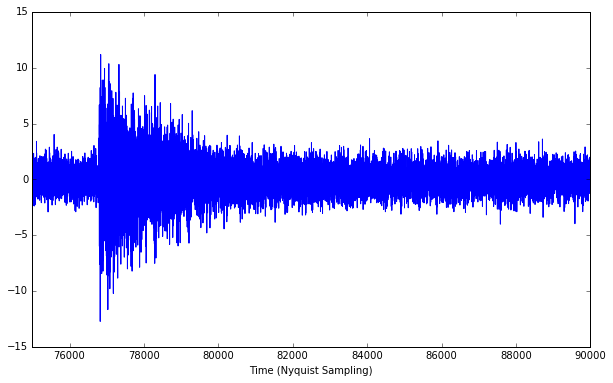

In [5]:
""" Generate two pulses with different SN but same IRF """

%matplotlib inline

length = 153600
t = np.arange(length)
g = ( np.exp(-t / 390. / 3.) + 0j )[:length//2]
g *=  ( np.random.normal(size=g.shape) + 1j*np.random.normal(size=g.shape) )
g *= np.exp(2j*np.pi*np.random.random(length//2))

irf = np.fft.fft(g)
irf = np.lib.pad(irf, (0,1), 'constant', constant_values=(0+0j))

p_irf = simGP(4, irf, 1)

print(np.std(p_irf[76600:76600+1024*3]))
print(np.std(p_irf[:1024*3]))

plt.figure(figsize=(10,6))

plt.plot(p_irf)
plt.ylim(-15, 15)
plt.xlim(75000,90000)

plt.xlabel('Time (Nyquist Sampling)')

In [ ]:
""" De-Scattering Loop to Determine SN corrections """

# Create IRF

# Exponential tail
g = ( np.exp(-t / 390. / 3.) + 0j )[:length//2]
# Random Phases
g *= np.exp(2j*np.pi*np.random.random(length//2))
# Multiply by noise: g is just noise with variances drawn from an exponential
g *=  ( np.random.normal(size=g.shape) + 1j*np.random.normal(size=g.shape) )

plt.plot(g[:4096])

irf = np.fft.fft(g)
irf = np.lib.pad(irf, (0,1), 'constant', constant_values=(0+0j))

cchan = 16*3
fchan = 512*3
pchan = 16*3 # Channelization of 1 microsecond to align profiles

cratio = pchan // cchan

SN = []
P = []
Pnoise = []

# logarithmic spacing

n = 20
m = 100

pnom = np.zeros((n,m))
pdenom = np.zeros((n,m))

j = 0
for sn in np.linspace(0,2,n):
    #pratio = []
    sntemp = []
    for x in range(m):
        p_irf = simGP(10**(sn), irf, 1)
        sntemp.append(np.std(p_irf[76800:76800+1024*3])**2 / np.std(p_irf[:1024*3])**2 - 1 )
    sntemp = np.array(sntemp)    
    SN.append( np.mean(sntemp) )

    #p_irf = np.roll(p_irf, int(np.random.randn(1)*len(irf)) )
    p1 = channelize_ts(p_irf, 256*3)

    p1prof = (abs(rechannelize(p1,pchan))**2.0).sum(-1)
    p1temp = np.roll(rechannelize(p1,cchan), cratio*(518-np.argmax(p1prof)), axis=0)

    for i in range(m):
        p2 = simGP(10**sn, irf, 1)
        #p2 = simGP(10, irf, 1)  
        #p2 = np.roll(p2, int(np.random.randn(1)*len(irf)) )

        p2 = channelize_ts(p2, 256*3)

        p2prof = (abs(rechannelize(p2,pchan))**2.0).sum(-1)
        p2temp = np.roll(rechannelize(p2,cchan), cratio*(518-np.argmax(p2prof)), axis=0)

        p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
        p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
        p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)

        p11pcorr = (abs(p22pcorr)**2.0).sum(1)
        p22pcorr = (abs(p22pcorr)**2.0).sum(1)

        Npeak = p11pcorr.shape[0]*cchan/fchan
        p11max = max(p11pcorr) - np.sort(p11pcorr)[-Npeak:-2*(Npeak//50)].mean()
        p22max = max(p22pcorr) - np.sort(p22pcorr)[-Npeak:-2*(Npeak//50)].mean()
        corrnorm = 1.

        pcross = max( (abs(p12pcorr[cratio*511:cratio*577])**2.0).sum(1) ) - (
                    abs(p12pcorr[cratio*50:cratio*450])**2.0).sum(1).mean(0) 

        pauto = np.sqrt(p11max*p22max)

        pnom[j,i] = pcross
        pdenom[j,i] = pauto
        #pratio.append(pcross / pauto)
   
    #pr1 = 1*np.array(pratio)

    #P.append(pr1.mean())
    #Pnoise.append(pr1.std())
    
    j += 1

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [62]:
""" De-Scattering Loop closer to Marten's Measurement """

# Create IRF

# Exponential tail
g = ( np.exp(-t / 390. / 3.) + 0j )[:length//2]
# Random Phases
g *= np.exp(2j*np.pi*np.random.random(length//2))
# Add noise, so expectation value lies a
g *=  ( np.random.normal(size=g.shape) + 1j*np.random.normal(size=g.shape) )

irf = np.fft.fft(g)
irf = np.lib.pad(irf, (0,1), 'constant', constant_values=(0+0j))


cchan = 16*3
fchan = 512*3
pchan = 16*3 # Channelization of 1 microsecond to align profiles

cratio = pchan // cchan

SN = []
P = []
Pnoise = []

# logarithmic spacing

n = 20
m = 100

pnom = np.zeros((n,m))
pdenom = np.zeros((n,m))

j = 0
for sn in np.linspace(0,2,n):
    #pratio = []
    sntemp = []
    for x in range(m):
        p_irf = simGP(10**(sn), irf, 1)
        sntemp.append(np.std(p_irf[76800:76800+1024*3])**2 / np.std(p_irf[:1024*3])**2 - 1 )
    sntemp = np.array(sntemp)    
    SN.append( np.mean(sntemp) )

    p1 = channelize_ts(p_irf, 256*3)

    p1prof = (abs(rechannelize(p1,pchan))**2.0).sum(-1)
    p1temp = np.roll(rechannelize(p1,cchan), cratio*(518-np.argmax(p1prof)), axis=0)

    for i in range(m):
        p2 = simGP(10**sn, irf, 1)
        #p2 = simGP(10, irf, 1)

        p2 = channelize_ts(p2, 256*3)

        p2prof = (abs(rechannelize(p2,pchan))**2.0).sum(-1)
        p2temp = np.roll(rechannelize(p2,cchan), (518-np.argmax(p2prof)), axis=0)

        p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
        p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
        p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)

        p11pcorr = (abs(p22pcorr)**2.0).sum(1)
        p22pcorr = (abs(p22pcorr)**2.0).sum(1)

        Npeak = p11pcorr.shape[0]*cchan/fchan
        corrnorm = 1.

        p11max = max(p11pcorr) - np.mean(p11pcorr[513:577])
        p22max = max(p22pcorr) - np.mean(p22pcorr[513:577])
        
        pcross = max( (abs(p12pcorr[511:577])**2.0).sum(1) ) - (
                    abs(p12pcorr[513:577])**2.0).sum(1).mean(0) 
        
        #pauto = np.sqrt(p11max*p22max)
        p2_power = (np.abs(p2temp)**2.0)
        pauto = (p2_power[512:512+64] - p2_power[:511].mean(0, keepdims=True)).sum()
        
        pnom[j,i] = pcross
        pdenom[j,i] = pauto
        #pratio.append(pcross / pauto)
   
    #pr1 = 1*np.array(pratio)

    #P.append(pr1.mean())
    #Pnoise.append(pr1.std())
    
    j += 1

[ 121229.227352      1141.37982899     978.47332091 ...,     956.73334547
     978.25855949     966.8184158 ]


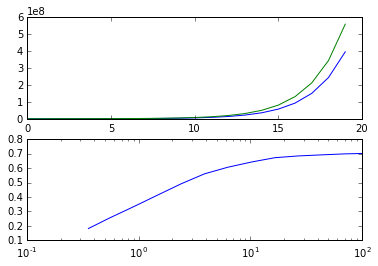

In [63]:
print p11pcorr

plt.subplot(211)
plt.plot(pnom.mean(axis=-1))
plt.plot(pdenom.mean(axis=-1))

P = (pnom.mean(-1) / pdenom.mean(-1))
Pmed = (np.median(pnom, axis=-1) / np.median(pdenom, axis=-1))
Pnoise = (pnom / pdenom).std(-1)

plt.subplot(212)

plt.plot(SN, P)
plt.xlim(0.1,100)
plt.xscale('log')

512


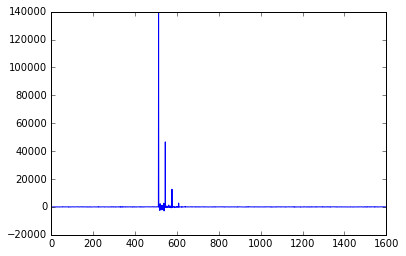

In [64]:
plt.plot(p12pcorr.sum(-1))

print np.argmax(p12pcorr.sum(-1))

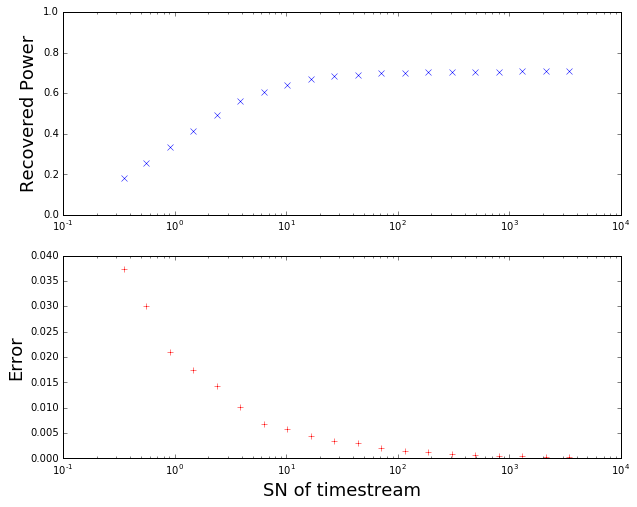

In [65]:
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(SN, P, 'bx')

plt.ylim(0,1)
plt.xscale('log')
plt.ylabel('Recovered Power', fontsize=18)

plt.subplot(212)
plt.plot(SN, Pnoise, 'r+')
#plt.ylim(0,0.1)

plt.ylabel('Error', fontsize=18)
plt.xlabel('SN of timestream', fontsize=18)

plt.xscale('log')

In [70]:
xtest = SN[:12]
ytest1 = P[:12]
ytest2 = Pnoise[:12]

z = np.polyfit(xtest, ytest1, 8)
np.save('SNcorrectionPol.npy',z)
ptest1 = np.poly1d(z)

z = np.polyfit(xtest, ytest2, 8)
np.save('SNnoisePol.npy',z)
ptest2 = np.poly1d(z)

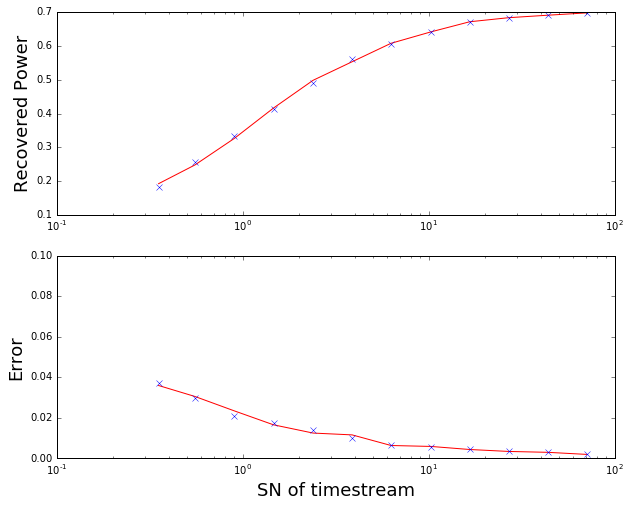

In [71]:
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(xtest, ptest1(xtest), 'r')
plt.plot(xtest, ytest1, 'bx')
plt.xscale('log')
plt.ylabel('Recovered Power', fontsize=18)

plt.subplot(212)
plt.plot(xtest, ptest2(xtest), 'r')
plt.plot(xtest, ytest2, 'bx')
plt.xscale('log')
plt.ylim(0,0.1)

plt.ylabel('Error', fontsize=18)
plt.xlabel('SN of timestream', fontsize=18)


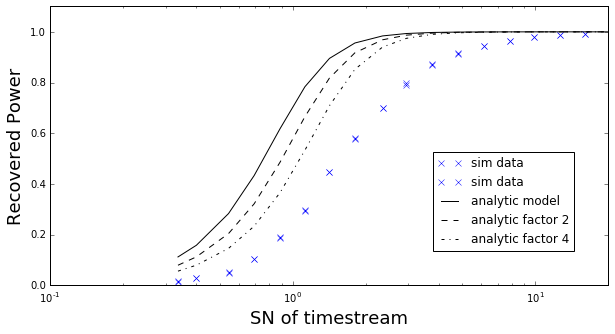

In [59]:
""" Add  """
def SNmodel(SN):
    return 1./np.sqrt(1+SN**(-2.0))

def SNmodel2(SN):
    return 1./np.sqrt(1+2*SN**(-2.0))

def SNmodel4(SN):
    return 1./np.sqrt(1+4*SN**(-2.0))

def SNmodel22(SN):
    return 1./np.sqrt(2+4*SN**(-2.0))

xtest = np.array(xtest)

xt = np.sqrt(xtest)

plt.figure(figsize=(10,5))

plt.plot(xt, ytest1, 'bx', label='sim data')
plt.plot(xt, Pmed[1:], 'bx', label='sim data')

#plt.plot( np.sqrt(xtest), ptest1(xtest), 'r', label='sim fit')

plt.plot(xt, SNmodel(np.array(xtest)), 'k', label='analytic model')
plt.plot(xt, SNmodel2(np.array(xtest)), 'k--', label='analytic factor 2')
plt.plot(xt, SNmodel4(np.array(xtest)), 'k-.', label='analytic factor 4')
plt.xscale('log')
plt.ylabel('Recovered Power', fontsize=18)

plt.xlim(0.1, 20)

plt.legend(bbox_to_anchor=(0.95, 0.5))

#plt.subplot(212)
#plt.plot(xtest, ptest2(xtest), 'r')
#plt.plot(xtest, ytest2, 'bx')
#plt.xscale('log')
plt.ylim(0,1.1)

#plt.ylabel('Error', fontsize=18)
plt.xlabel('SN of timestream', fontsize=18)


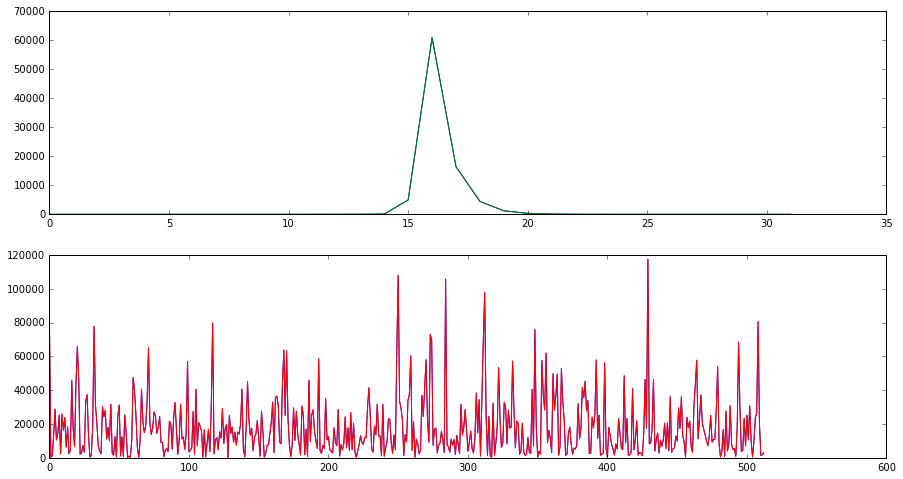

In [8]:
""" Check Correlation Coefficient Calculation """

nyq_pad = np.zeros((100,1))

length = 2**15
t = np.arange(length)
g = ( np.exp(-t / 390.) + 0j )[:length//2]
g *= np.exp(2j*np.pi*np.random.random(length//2))

irf = np.fft.fft(g)
irf = np.lib.pad(irf, (0,1), 'constant', constant_values=(0+0j))

pt1 = simGP(10, irf, 0)
pt2 = simGP(10, irf, 0)

p1chan = channelize_ts(pt1, 512)
p2chan = channelize_ts(pt2, 512)

plt.figure(figsize=(15,8))

plt.subplot(211)
plt.plot(abs(p1chan).sum(-1))
plt.plot(abs(p2chan).sum(-1))

#plt.xlim(70,85)

plt.subplot(212)
plt.plot((np.abs(p1chan[16])**2.0))
plt.plot((np.abs(p2chan[16])**2.0) , 'r')



1.0


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in sqrt


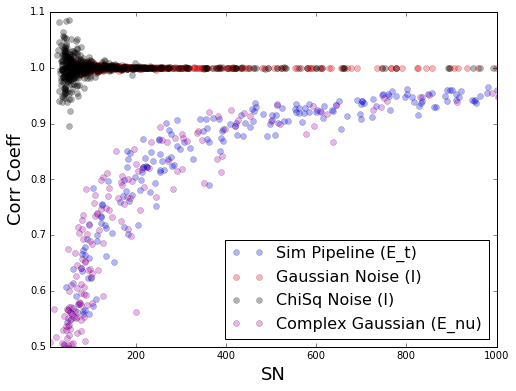

In [38]:
def ExtractPulse(x):
    
    pulse = x[16]
    noise = x[:10] #.mean(0)
    #bg = x[15:70]#.mean(0)

    GP = pulse #- bg
    n = noise #- bg

    return GP, noise

def CorrPulses(GP1, N1, GP2, N2):
    autoc = (GP1 - np.mean(GP1))  * (GP2 - np.mean(GP2))

    std1 = np.std(GP1)**2.0 - np.std(N1)**2.0
    std2 = np.std(GP2)**2.0 - np.std(N2)**2.0
    
    #std1 = np.std(GP1)**2.0 - np.mean(N1**2.0)
    #std2 = np.std(GP2)**2.0 - np.mean(N2**2.0)
    
    corr = np.mean(autoc) / np.sqrt(std1 * std2)
    return corr

Carray = []
Cgauss = []
CX = []
Ccomp = []
SN1 = []
SN2 = []
SN3 = []
SN4 = []

N = 500

for i in range(N):
    pt1 = simGP(30.*i/N, irf, 1)
    pt2 = simGP(30.*i/N, irf, 1)

    p1chan = channelize_ts(pt1, 512)
    p2chan = channelize_ts(pt2, 512)
    
    GP1, N1 = ExtractPulse(np.abs(p1chan)**2.0)
    GP2, N2 = ExtractPulse(np.abs(p2chan)**2.0)

    profile = (np.abs(p1chan)**2.0).sum(1)
    SN1.append((profile[16] - np.mean(profile[:12]))/np.std(profile[:12]))
    
    cc = CorrPulses(GP1[1:-1], N1[1:-1], GP2[1:-1], N2[1:-1])
    Carray.append(cc)
    
    if i == 0:
        AutoTest = CorrPulses(GP1, 0, GP1, 0)
        print AutoTest
    
for i in range(N):
    ptg = simGP(3, irf, 0)
    pgchan = channelize_ts(ptg, 512)
    G1 = np.abs(pgchan)**2.0 + np.random.normal(scale=i+1, size=pgchan.shape)
    G2 = np.abs(pgchan)**2.0 + np.random.normal(scale=i+1, size=pgchan.shape)
    
    GaussGP1, GaussN1 = ExtractPulse(G1)
    GaussGP2, GaussN2 = ExtractPulse(G2)

    ccgauss = CorrPulses(GaussGP1, GaussN1, GaussGP2, GaussN2)
    Cgauss.append(ccgauss)
    profile = G1.sum(1)
    SN2.append((profile[16] - np.mean(profile[:12]))/np.std(profile[:12])) 
               
for i in range(N):
    ptX = simGP(3, irf, 0)
    pXchan = channelize_ts(ptX, 512)
    G1 = np.abs(pXchan)**2.0 + i*np.random.chisquare(df=2, size=pgchan.shape)
    G2 = np.abs(pXchan)**2.0 + i*np.random.chisquare(df=2, size=pgchan.shape)
    
    XGP1, XN1 = ExtractPulse(G1)
    XGP2, XN2 = ExtractPulse(G2)

    ccX = CorrPulses(XGP1, XN1, XGP2, XN2)
    CX.append(ccX)
    profile = G1.sum(1)
    SN3.append((profile[16] - np.mean(profile[:12]))/np.std(profile[:12])) 

for i in range(N):
    ptg = simGP(3, irf, 0)
    pgchan = channelize_ts(ptg, 512)
    n1 = np.random.normal(scale=(i+1)/10., size=(32, 513, 2))
    n2 = np.random.normal(scale=(i+1)/10., size=(32, 513, 2))
    G1 = np.abs(pgchan + n1[...,0] + 1j*n1[...,1])**2.0
    G2 = np.abs(pgchan + n2[...,0] + 1j*n2[...,1])**2.0
    
    GaussGP1, GaussN1 = ExtractPulse(G1)
    GaussGP2, GaussN2 = ExtractPulse(G2)

    ccgauss = CorrPulses(GaussGP1, GaussN1, GaussGP2, GaussN2)
    Ccomp.append(ccgauss)
               
    profile = G1.sum(1)
    SN4.append((profile[16] - np.mean(profile[:12]))/np.std(profile[:12]) )
    
plt.figure(figsize=(8,6))
plt.ylim(0.5, 1.1)
plt.xlim(10,1000)

plt.plot(SN1, Carray, 'bo', alpha=0.3, label='Sim Pipeline (E_t)')
plt.plot(SN2, Cgauss, 'ro', alpha=0.3, label='Gaussian Noise (I)')
plt.plot(SN3, CX, 'ko', alpha=0.3, label='ChiSq Noise (I)')
plt.plot(SN4, Ccomp, 'mo', alpha=0.3, label='Complex Gaussian (E_nu)')

plt.xlabel('SN', fontsize=18)
plt.ylabel('Corr Coeff', fontsize=18)

plt.legend(fontsize=16, loc=4)


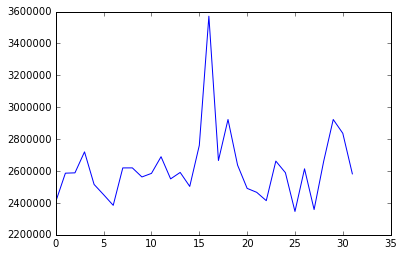

In [39]:
plt.plot(profile)

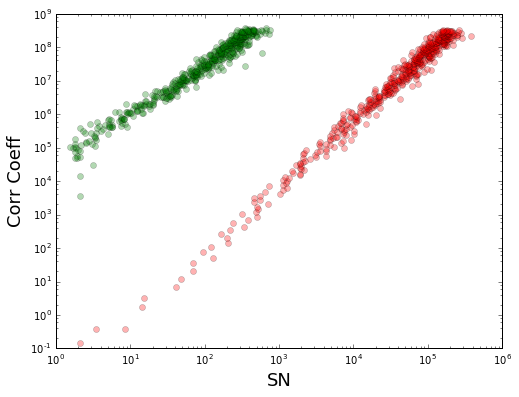

In [32]:
def ExtractPulse(x):
    
    pulse = x[16]
    noise = x[:10] #.mean(0)
    #bg = x[15:70]#.mean(0)

    GP = pulse #- bg
    n = noise #- bg

    return GP, noise

def CorrPulses(GP1, N1, GP2, N2):
    autoc = (GP1 - np.mean(GP1))  * (GP2 - np.mean(GP2))

    std1 = np.std(GP1)**2.0 - np.std(N1)**2.0
    std2 = np.std(GP2)**2.0 - np.std(N2)**2.0
    
    #std1 = np.std(GP1)**2.0 - np.mean(N1**2.0)
    #std2 = np.std(GP2)**2.0 - np.mean(N2**2.0)
    
    corr = np.mean(autoc) / np.sqrt(std1 * std2)
    return corr

SN1 = []
SN2 = []

NM1 = []
NS1 = []
NP1 = []
NM2 = []
NS2 = []
NP2 = []

N = 500

for i in range(N):
    pt1 = simGP(10.*i/N, irf, 1)
    pt2 = simGP(10.*i/N, irf, 1)

    p1chan = channelize_ts(pt1, 512)
    p2chan = channelize_ts(pt2, 512)
    
    GP1, N1 = ExtractPulse(np.abs(p1chan)**2.0)
    GP2, N2 = ExtractPulse(np.abs(p2chan)**2.0)

    Gsummed1 = (np.abs(p1chan)**2.0).sum(1)
    SN1.append((np.max(Gsummed1) - Gsummed1[:12].mean())/ Gsummed1[:12].std())
    NM1.append(N1.mean())
    NS1.append(N1.std(axis=1).mean(axis=0)**2.0)
    NP1.append(GP1.std()**2.0)


for i in range(N):
    ptX = simGP(10.*i/N, irf, 0)
    pXchan = channelize_ts(ptX, 512)
    G1 = np.abs(pXchan)**2.0 + np.random.chisquare(df=2, size=pXchan.shape)
    G2 = np.abs(pXchan)**2.0 + np.random.chisquare(df=2, size=pXchan.shape)
    
    GP1, N1 = ExtractPulse(G1)
    GP2, N2 = ExtractPulse(G2)

    Gsummed1 = G1.sum(1)
    SN2.append((np.max(Gsummed1) - Gsummed1[:12].mean())/ Gsummed1[:12].std())
    NM2.append(N1.mean())
    NS2.append(N1.std(axis=1).mean(axis=0)**2.0)
    NP2.append(GP1.std()**2.0)

    
plt.figure(figsize=(8,6))

#plt.plot(SN1, NM1, 'bo', alpha=0.3, label='Sim Pipeline (E_t)')
plt.plot(SN2, np.array(NP2)-np.array(NS2), 'ro', alpha=0.3, label='Gaussian Noise (E_t)')
plt.plot(SN1, np.array(NP1)-np.array(NS1), 'go', alpha=0.3, label='Chi Sq noise (I)')

#plt.plot(SN2, NM2, 'ro', alpha=0.3, label='Gaussian Noise (E_t)')
#plt.plot(SN1, NM1, 'go', alpha=0.3, label='Chi Sq noise (I)')

plt.xlabel('SN', fontsize=18)
plt.ylabel('Corr Coeff', fontsize=18)

plt.xscale('log')
plt.yscale('log')

#plt.legend(fontsize=16, loc=4)


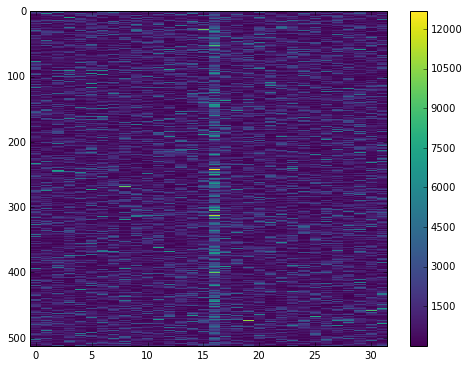

In [101]:
plt.figure(figsize=(8,6))

plt.imshow( G1.T, cmap=cm.viridis, aspect='auto', interpolation='nearest')
plt.colorbar()
#plt.plot(N1)

0.495030329349


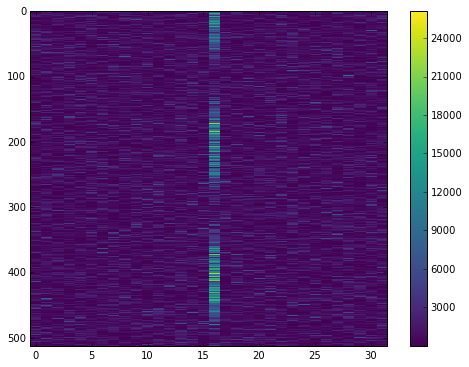

In [107]:
plt.figure(figsize=(8,6))

ts_noise1 = np.random.normal(size=length)
ts_noise1[length//2] += 50
ts_noise1[length//2 + 5] += 50
ft_noise1 = np.fft.rfft(ts_noise1.reshape(-1, 1024), axis=-1)
power_noise1 = (abs(ft_noise1)**2.0)

ts_noise2 = np.random.normal(size=length)
ts_noise2[length//2] += 50
ts_noise2[length//2 + 5] += 50
ft_noise2 = np.fft.rfft(ts_noise2.reshape(-1, 1024), axis=-1)
power_noise2 = (abs(ft_noise2)**2.0)

g1, n1 = ExtractPulse(power_noise1)
g2, n2 = ExtractPulse(power_noise2)

ctest = CorrPulses(g1, n1, g2, n2)
print ctest

plt.imshow(power_noise1.T, aspect='auto', interpolation='nearest', cmap=cm.viridis)
plt.colorbar()

In [54]:
a = 4.*np.random.normal(size=1e6)

b = a**2.0

print(a.std())
print(b.std())

print np.sqrt(2)*4**2

3.99627395049
22.6256578786
22.627416998


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


5.16604458282e-05 1.98532519738
2.21252481106e-06 2.02362064518
1.80276423898 3.91067928156
1.80093147019 3.92425422378
14.5823995424 3.2433541603


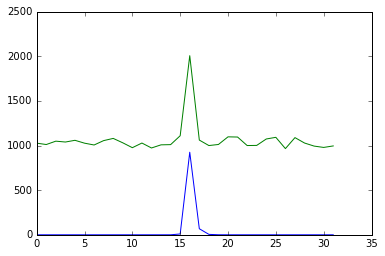

In [171]:
pt = simGP(0.1, irf, 0)
pchan = channelize_ts(pt, 512)

G1 = np.abs(pchan)**2.0 #+ np.random.chisquare(df=2, size=pchan.shape)
G2 = pchan + np.random.normal(scale=1, size=pchan.shape) + 1j*np.random.normal(scale=1, size=pchan.shape)

G2 = np.abs(G2)**2.0

plt.plot(G1.sum(-1))
plt.plot(G2.sum(-1))

print G1[:10].std(), G2[:10].std()
print G1[:10].mean(), G2[:10].mean()
print G1[16].mean(), G2[16].mean()
print G1[16].std(), G2[16].std()
print (G2[16].mean()-G2[:10].mean())**2.0 * G2[:10].mean()**2.0, G1[16].std()**2.0

In [172]:
var_pulse = G1[16].std()**2.0
mean_pulse = G1[16].mean()


var_n = G2[:10].std()**2.0
var_g = G2[16].std()**2.0

mean_n = G2[:10].mean()
mean_g = G2[16].mean()

print var_pulse, mean_pulse

print var_g, var_n, 2*(mean_g - mean_n)*mean_n
print var_g -  var_n - 2*np.sqrt(var_pulse*var_n)
print var_g - var_n - 2*(mean_g - mean_n)*mean_n

corr_frominput = []
corr_frommeas = []


3.2433541603 1.80276423898
15.3997712129 3.94151613935 7.63738163047
4.3073858205
3.82087344306


ValueError: could not convert string to float: k--

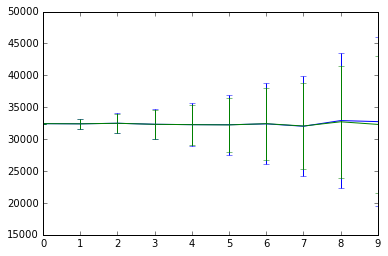

In [189]:
n = 1000
m = 10

corr_frominput = np.zeros((m,n))
corr_frommeas = np.zeros((m,n))
var_real = np.zeros((m,n))

for k in range(m):
    for i in range(n):

        pt = simGP(1, irf, 0)
        pchan = channelize_ts(pt, 512)

        G1 = np.abs(pchan)**2.0 #+ np.random.chisquare(df=2, size=pchan.shape)
        G2 = pchan + k*(np.random.normal(scale=1, size=pchan.shape) 
                      + 1j*np.random.normal(scale=1, size=pchan.shape))

        G2 = np.abs(G2)**2.0

        var_pulse = G1[16].std()**2.0
        mean_pulse = G1[16].mean()


        var_n = G2[:10].std()**2.0
        var_g = G2[16].std()**2.0

        mean_n = G2[:10].mean()
        mean_g = G2[16].mean()

        corr_frominput[k,i] = (var_g -  var_n - 2*np.sqrt(var_pulse*var_n))
        corr_frommeas[k,i] = (var_g - var_n - 2*(mean_g - mean_n)*mean_n)
        var_real[k,i] = (var_pulse)


plt.errorbar(np.arange(10), corr_frominput.mean(axis=1), yerr=corr_frominput.std(axis=1))
plt.errorbar(np.arange(10), corr_frommeas.mean(axis=1), yerr=corr_frommeas.std(axis=1))
plt.axhline(np.mean(var_real), 'k--')

print np.array(corr_frominput).mean()
print np.array(corr_frommeas).mean()
print np.array(var_real).mean()

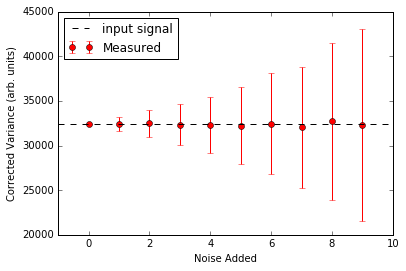

In [198]:
#plt.errorbar(np.arange(10), corr_frominput.mean(axis=1), yerr=corr_frominput.std(axis=1), fmt='o', color='b',
#            label)
plt.errorbar(np.arange(10), corr_frommeas.mean(axis=1), yerr=corr_frommeas.std(axis=1), fmt='o', color='r',
            label='Measured')
plt.axhline(np.mean(var_real), color='k', linestyle='--', label='input signal')
plt.xlim(-1,10)

plt.xlabel('Noise Added')
plt.ylabel('Corrected Variance (arb. units)')
plt.legend(loc=2)

In [192]:
plt.axhline?

In [142]:

pt = simGP(0.1, irf, 0)
pchan = channelize_ts(pt, 512)

G1 = np.abs(pchan)**2.0 + np.random.chisquare(df=2, size=pchan.shape)
G2 = np.abs(pchan)**2.0 + np.random.chisquare(df=2, size=pchan.shape)

GaussGP1, GaussN1 = ExtractPulse(G1)
GaussGP2, GaussN2 = ExtractPulse(G2)

ccgauss = CorrPulses(GaussGP1, GaussN1, GaussGP2, GaussN2)

print ccgauss

0.933477035136


In [93]:
pt = simGP(0.1, irf, 0)
pchan = channelize_ts(pt, 512)

G1 = pchan + np.random.normal(scale=1, size=pchan.shape) + 1j*np.random.normal(scale=1, size=pchan.shape)
G1 = np.abs(G1)**2.0

G2 = pchan + np.random.normal(scale=1, size=pchan.shape) + 1j*np.random.normal(scale=1, size=pchan.shape)
G2 = np.abs(G2)**2.0

GaussGP1, GaussN1 = ExtractPulse(G1)
GaussGP2, GaussN2 = ExtractPulse(G2)

ccgauss = CorrPulses(GaussGP1, GaussN1, GaussGP2, GaussN2)

print ccgauss

0.977896804199


(0, 512)

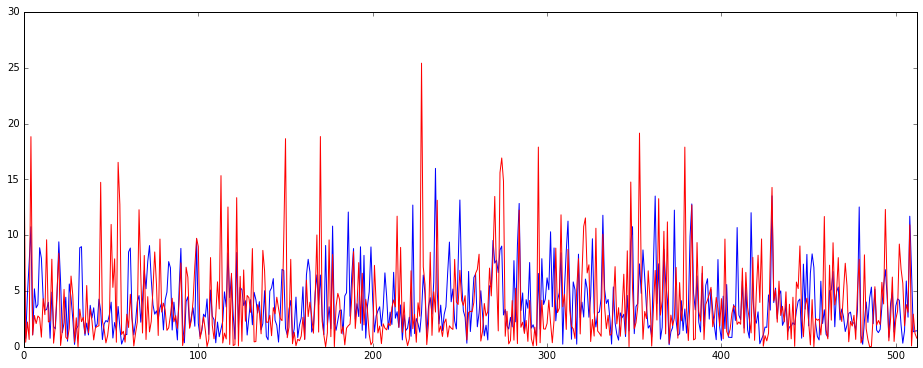

In [127]:
plt.figure(figsize=(16,6))

plt.plot(G1[16])
plt.plot(G2[16], 'r')

plt.xlim(0,512)